# Short-term Temperature Model Test

## Import dependencies and data

In [1]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'
save_path = home_path + '\\model\\saved\\'

In [119]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.loc[:, ('time', 'date')] = pd.to_datetime(data.time.date)

In [120]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101'),
#     ('flow', 'FF01_GP101'),
#     ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT101_GM101'),
    ('temperatures', 'DC_GT102_GM102'),
    ('temperatures', 'DC_GT103_GM103'),
    ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('setpoints', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'vol'),
    ('time', 'mod'),
    ('time', 'doy')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

In [121]:
# # RESAMPLE to MINUTE-FREQ

# data = data.groupby(['month', 'day', 'hour', 'minute']).agg({
#     ('flow', 'TA01_GP101'):'sum',
#     ('temperatures', 'DC_GT101_GM101'):'mean',
#     ('temperatures', 'DC_GT102_GM102'):'mean',
#     ('temperatures', 'DC_GT103_GM103'):'mean',
#     ('temperatures', 'DC_GT104_GM104'):'mean',
#     ('temperatures', 'DC_GT401_GM401'):['sum', 'mean'],
#     ('temperatures', 'DC_GT301_damped'):'mean',  # REMOVE?
#     ('temperatures', 'DC_GT301_outdoor'):'mean', # REMOVE?
#     ('setpoints', 'TA01_GT10X_GM10X'):'mean',
#     ('sun', 'gsi'):'sum',
#     ('sun', 'vol'):'sum',
#     ('time', 'mod'):'mean',
#     ('time', 'doy'):'mean'
# })

## Describe Df

In [122]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category      sensor_ID       
flow          TA01_GP101          13
temperatures  DC_GT101_GM101      12
              DC_GT102_GM102      12
              DC_GT103_GM103      11
              DC_GT104_GM104      11
              DC_GT401_GM401      13
              DC_GT301_damped     11
              DC_GT301_outdoor    12
setpoints     TA01_GT10X_GM10X    14
sun           gsi                  1
              vol                  1
time          mod                  1
              doy                  1
dtype: int64





In [123]:
# remove single NAN
data = data.dropna(how='any')

In [124]:
# describe cols
data.describe().transpose()

count         mean         std  \
category     sensor_ID                                             
flow         TA01_GP101        256305.0  2350.244315  606.494982   
temperatures DC_GT101_GM101    256305.0    17.493360   11.283247   
             DC_GT102_GM102    256305.0    20.384812    1.248066   
             DC_GT103_GM103    256305.0    20.963232    1.546712   
             DC_GT104_GM104    256305.0    20.852924    1.618207   
             DC_GT401_GM401    256305.0    49.457762    3.449051   
             DC_GT301_damped   256305.0    -5.075539    6.692217   
             DC_GT301_outdoor  256305.0    -5.044680    6.653598   
setpoints    TA01_GT10X_GM10X  256305.0    20.661796    0.752597   
sun          gsi               256305.0    29.613705   73.869739   
             vol               256305.0   341.132069  959.526231   
time         mod               256305.0     0.631368    0.306814   
             doy               256305.0     0.316664    0.202923   

                                        min          25%          50%  \
category     sensor_ID                                                  
flow         TA01_GP101        1.761400e+03  1860.000000  2059.000000   
temperatures DC_GT101_GM101   -1.990000e+01    19.600000    20.500000   
             DC_GT102_GM102    1.240000e+01    19.600000    20.300000   
             DC_GT103_GM103    1.040000e+01    20.000000    20.600000   
             DC_GT104_GM104    1.080000e+01    19.800000    20.400000   
             DC_GT401_GM401    1.540000e+01    48.700000    50.200000   
             DC_GT301_damped  -2.160000e+01   -10.400000    -3.800000   
             DC_GT301_outdoor -2.090000e+01   -10.300000    -3.700000   
setpoints    TA01_GT10X_GM10X  2.000000e+01    20.000000    20.000000   
sun          gsi               0.000000e+00     0.000000     0.003810   
             vol               0.000000e+00     0.000000     0.000000   
time         mod               0.000000e+00     0.378649     0.697790   
             doy               1.224647e-16     0.128748     0.296713   

                                       75%          max  
category     sensor_ID                                   
flow         TA01_GP101        2738.400000  4206.600000  
temperatures DC_GT101_GM101      21.500000    29.000000  
             DC_GT102_GM102      21.000000    30.300000  
             DC_GT103_GM103      21.700000    31.000000  
             DC_GT104_GM104      21.600000    32.100000  
             DC_GT401_GM401      51.200000    56.200000  
             DC_GT301_damped      0.100000     9.300000  
             DC_GT301_outdoor     0.300000     8.400000  
setpoints    TA01_GT10X_GM10X    21.500000    22.100000  
sun          gsi                 10.347244   491.320000  
             vol                  0.253372  3600.000000  
time         mod                  0.917060     1.000000  
             doy                  0.501242     0.668064

## Process / transform variables 

In [125]:
### create "better" temperature var

# data[('temperatures', 'TA01_GT10X_GM10X')] = data.temperatures[['DC_GT101_GM101', 'DC_GT102_GM102', 'DC_GT103_GM103', 'DC_GT104_GM104']].values.mean(axis=1)
data[('temperatures', 'TA01_GT10X_GM10X')] = data.temperatures[[
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

data[('temperatures', 'TA01_GT10X_GM10X')] = data[('temperatures', 'TA01_GT10X_GM10X')] - (data[('setpoints', 'TA01_GT10X_GM10X')] - 20.0)

In [126]:
# make OUTDOOR temp always NEGATIVE (i.e. between [MIN, 0])
data[('temperatures', 'DC_GT301_damped')] = data[('temperatures', 'DC_GT301_damped')] - data[('temperatures', 'DC_GT301_damped')].max()
data[('temperatures', 'DC_GT301_outdoor')] = data[('temperatures', 'DC_GT301_outdoor')] - data[('temperatures', 'DC_GT301_outdoor')].max()

In [127]:
# # perform FFT 
# fourier = np.fft.rfft(data.temperatures.DC_GT401_GM401.values)

# # get FREQS
# spacing = 1 / 10 # i.e. 1/10th of cycle PER step, due to 5-min cycles.
# freqs = np.fft.rfftfreq(
#     n = len(data),
#     d = spacing
# )

# # filter fourier series
# threshold = 1
# fourier[freqs > threshold] = 0
# filtered = np.fft.irfft(fourier)

# # put in data
# data.loc[:, ('temperatures', 'DC_GT401_GM401_fft')] = data[('temperatures', 'DC_GT401_GM401')]
# data[('temperatures', 'DC_GT401_GM401_fft')] = filtered

In [128]:
# plt.plot(data[data.flow.TA01_GP101 > 4000].temperatures.TA01_GT10X_GM10X.values[-100:])

In [129]:
# # USE only a few days
# data = data[(data.index.get_level_values(0) == 3) & (data.index.get_level_values(1) > 15)].copy()

## Preparing data

In [357]:
t_steps = 15   # 15-min predictions

train_frac = 0.8

### Data selection and whitening

In [358]:
# # save temp mean & std

temp_mean = data.temperatures.TA01_GT10X_GM10X.mean()
temp_std = data.temperatures.TA01_GT10X_GM10X.std()

In [359]:
# normalize columns
cols = [
    ('temperatures', 'TA01_GT10X_GM10X'),
]

for col in cols:
    data[col] = (data[col] - data[col].mean()) / data[col].std()
    
# squeeze columns to [0, 1]
cols = [
    ('flow', 'TA01_GP101'),
    ('temperatures', 'DC_GT401_GM401'),
    ('sun', 'gsi'),
    ('sun', 'vol'),
    ('time', 'mod'),
#     ('time', 'doy')
]

for col in cols:
    data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min()) # squeeze vals between 0 and 1
    
# squeeze columns to [-1, 0]
cols = [
    ('temperatures', 'DC_GT301_damped'),
]

for col in cols:
    data[col] = (data[col] - data[col].max()) / (data[col].max() - data[col].min()) # squeeze vals between 0 and 1

In [360]:
# Define model variables
model_vars = [
    ('flow', 'TA01_GP101'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('sun', 'gsi'),
    ('sun', 'vol'),
    ('time', 'mod'),
    #('time', 'doy')
]

# filter data
testData = data[model_vars].copy()

In [361]:
targets = testData[('temperatures', 'TA01_GT10X_GM10X')].copy()

In [362]:
testData[('flow', 'TA01_GP101')] = testData[('flow', 'TA01_GP101')].rolling(t_steps).sum()
testData[('temperatures', 'TA01_GT10X_GM10X')] = testData[('temperatures', 'TA01_GT10X_GM10X')].rolling(t_steps).apply(lambda vec: vec[0], raw=True)
testData[('temperatures', 'DC_GT401_GM401')] = testData[('temperatures', 'DC_GT401_GM401')].rolling(t_steps).mean()
testData[('temperatures', 'DC_GT301_damped')] = testData[('temperatures', 'DC_GT301_damped')].rolling(t_steps).mean()
testData[('sun', 'gsi')] = testData[('sun', 'gsi')].rolling(t_steps).mean()
testData[('time', 'mod')] = testData[('time', 'mod')].rolling(t_steps).mean()

# testData = testData.iloc[t_steps:].copy()
# targets = targets.iloc[t_steps:].copy()
features = testData.iloc[t_steps:].values
targets = targets.iloc[t_steps:].values

### Shuffle and split dataset

In [363]:
# save sequential seqs, targets for testing
features, test_feats  = features[:-8640], features[-8640:]
targets, test_targets = targets[:-8640], targets[-8640:]

In [364]:
# get random indices
idxs = np.arange(len(targets))
np.random.shuffle(idxs)

# shuffle sequences and targets
features = np.squeeze(features[idxs])
targets = np.squeeze(targets[idxs])

In [365]:
# split data
train_n = int(len(targets) * train_frac)

X_train, X_test = features[:train_n], features[train_n:]
Y_train, Y_test = targets[:train_n], targets[train_n:]

In [366]:
# # delete vars
# del sequences, targets

## Define model

In [367]:
layerList = [
    layers.Input(shape=(
        X_train.shape[1],
#         X_train.shape[2]
    )),
    layers.BatchNormalization(),
    #layers.Dropout(rate=0.2),
    layers.Dense(
        units=512,
        activation='relu',
        activity_regularizer='l2'
    ),
    layers.BatchNormalization(),
    #layers.Dropout(rate=0.5),
    layers.Dense(
        units=512,
        activation='relu',
        activity_regularizer='l2'
    ),
    layers.BatchNormalization(),
    #layers.Dropout(rate=0.5),
    layers.Dense(
        units=512,
        activation='relu',
        activity_regularizer='l2'
    ),
    layers.BatchNormalization(),
#     layers.Dropout(rate=0.5),
    layers.Dense(
        units=1,
        activation=None,
        activity_regularizer='l2'
    )
]

In [368]:
# lr = 0.005
lr = 0.001
model = tf.keras.models.Sequential(layers=layerList, name='model')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_32 (Bat  (None, 7)                28        
 chNormalization)                                                
                                                                 
 dense_32 (Dense)            (None, 512)               4096      
                                                                 
 batch_normalization_33 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_33 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_34 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                             

In [369]:
trainHist = model.fit(
    X_train,
    Y_train,
    epochs=40,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
#         tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr * (0.9 ** epoch))
    ],
)

Epoch 1/40
1239/1239 [==============================] - 44s 31ms/step - loss: 0.9575 - val_loss: 0.3120
Epoch 2/40
1239/1239 [==============================] - 35s 28ms/step - loss: 0.1500 - val_loss: 0.1838
Epoch 3/40
1239/1239 [==============================] - 34s 28ms/step - loss: 0.1285 - val_loss: 0.1300
Epoch 4/40
1239/1239 [==============================] - 34s 27ms/step - loss: 0.1143 - val_loss: 0.2981
Epoch 5/40
1239/1239 [==============================] - 34s 27ms/step - loss: 0.1075 - val_loss: 0.3932
Epoch 6/40
1239/1239 [==============================] - 34s 27ms/step - loss: 0.1039 - val_loss: 0.8692
Epoch 7/40
1239/1239 [==============================] - 35s 28ms/step - loss: 0.0996 - val_loss: 0.1884
Epoch 8/40
1239/1239 [==============================] - 34s 28ms/step - loss: 0.1003 - val_loss: 0.2431


In [370]:
# model_name = 'temp_model_v9'
# model.save(save_path + model_name)

In [371]:
# model = tf.keras.models.load_model(save_path + 'temp_model_v6')

In [372]:
preds = model.predict(X_test)
vis_preds = model.predict(test_feats)

270/270 [==============================] - 2s 8ms/step


In [373]:
test_mae = np.abs(np.squeeze(preds) - Y_test) 
temp_diffs = test_mae# * temp_std

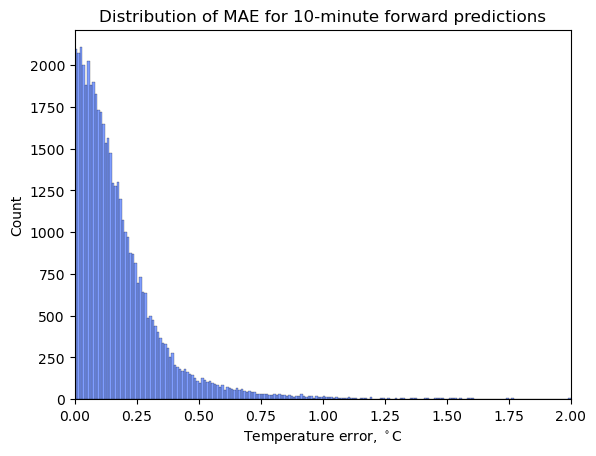

In [374]:
diff_df = pd.DataFrame(temp_diffs)

sns.histplot(
    data=diff_df,
    stat='count',
    binwidth=0.01,
    binrange=[0, 2.0],
    kde=False,
    palette='bright',
    legend=False
)

plt.title('Distribution of MAE for 10-minute forward predictions')
plt.xlim(0, 2.0)
plt.xlabel('Temperature error, $^\circ$C')

#plt.savefig(plot_path + 'temp_error_dist.png', bbox_inches='tight', dpi=200)
plt.show()

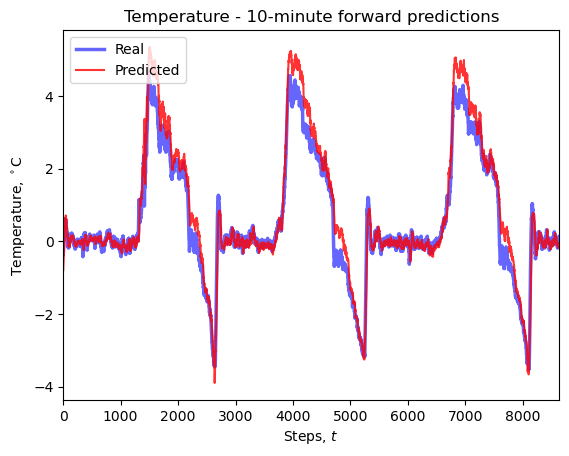

In [375]:
plt.plot(
    test_targets,# * temp_std + temp_mean,
    c='b',
    alpha=0.6,
    linewidth=2.5,
    label='Real'
)

plt.plot(
    np.squeeze(vis_preds),# * temp_std + temp_mean,
    c='r',
    alpha=0.8,
    linewidth=1.5,
    label='Predicted'
)

plt.ylabel('Temperature, $^\circ$C')
plt.xlabel('Steps, $t$')
plt.legend(loc='upper left')
plt.title('Temperature - 10-minute forward predictions')

#plt.ylim(15, 30)
plt.xlim(0, len(vis_preds))

#plt.savefig(plot_path + 'temp_preds_10min.png', bbox_inches='tight', dpi=200)

plt.show()

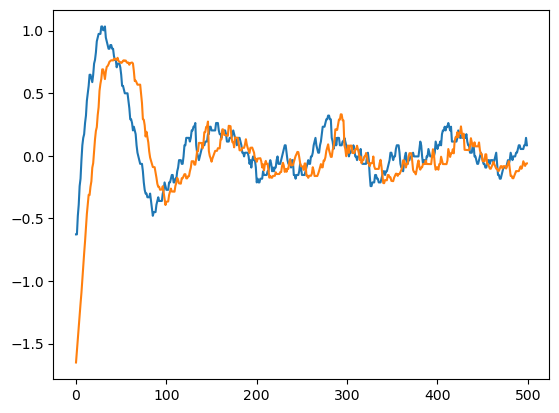

In [404]:
plt.plot(test_targets[-500:])
plt.plot(np.squeeze(vis_preds)[-500:])

In [376]:
# test_feats[:, 0] += 3.0
# vis_preds2 = model.predict(test_feats)

In [377]:
# plt.plot(test_targets[-600:])
# plt.plot(np.squeeze(vis_preds)[-600:])
# plt.plot(np.squeeze(vis_preds2)[-600:])

In [379]:
np.corrcoef(test_targets, np.squeeze(vis_preds))

array([[1.        , 0.98391668],
       [0.98391668, 1.        ]])